<img src = "logo.png" width=200px>

In [2]:
#Library used

#data analysis
import pandas as pd
import numpy as np

#data visualization
import matplotlib.pyplot as plt
from biokit.viz import corrplot
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import scatter_matrix
import matplotlib.cm as cm

plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (8,8)

#machine learnin
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import lasso_path
from sklearn.linear_model import LassoCV
from sklearn import cross_validation as cv
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


#Package for evaluating
from sklearn import metrics

from time import time

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Statistiques Descriptives
<hr style="border-width:2px;border-color:#3CB371">

In [3]:
#load data
table = pd.read_csv("OnlineNewsPopularity/OnlineNewsPopularity.csv")
X = table[table.columns[2:-1]]
Y = table[table.columns[-1:]]

n,p =X.shape
print("training size",n,"number of features",p,)

header = list(table)

# Verification NAN
NAN = table.isnull().values.any()
print("Existance of Not A Number :",NAN,)

table.describe()

training size 39644 number of features 58
Existance of Not A Number : False


,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
count,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,...,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000,39644.000000
mean,354.530471,10.398749,546.514731,0.548216,0.996469,0.689175,10.883690,3.293638,4.544143,1.249874,...,0.095446,0.756728,-0.259524,-0.521944,-0.107500,0.282353,0.071425,0.341843,0.156064,3395.380184
std,214.163767,2.114037,471.107508,3.520708,5.231231,3.264816,11.332017,3.855141,8.309434,4.107855,...,0.071315,0.247786,0.127726,0.290290,0.095373,0.324247,0.265450,0.188791,0.226294,11626.950749
min,8.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,1.000000
25%,164.000000,9.000000,246.000000,0.470870,1.000000,0.625739,4.000000,1.000000,1.000000,0.000000,...,0.050000,0.600000,-0.328383,-0.700000,-0.125000,0.000000,0.000000,0.166667,0.000000,946.000000
50%,339.000000,10.000000,409.000000,0.539226,1.000000,0.690476,8.000000,3.000000,1.000000,0.000000,...,0.100000,0.800000,-0.253333,-0.500000,-0.100000,0.150000,0.000000,0.500000,0.000000,1400.000000
75%,542.000000,12.000000,716.000000,0.608696,1.000000,0.754630,14.000000,4.000000,4.000000,1.000000,...,0.100000,1.000000,-0.186905,-0.300000,-0.050000,0.500000,0.150000,0.500000,0.250000,2800.000000
max,731.000000,23.000000,8474.000000,701.000000,1042.000000,650.000000,304.000000,116.000000,128.000000,91.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,843300.000000


**Remarque :**
- Le jeu de données ne contient pas de Na, cependant certaines valeurs anormales attirent  l'attention. En effet il semble que certaines caractéristiques représentantes des taux ont des valeurs supérieures à 1. (ex : n_unique tokens)
- De plus l'analyse des quantiles montre la présence d'outliers. 


In [4]:
# Issue rate
# Number of incorect observation
print("number of article with issue rate :",
      table[(table[' n_unique_tokens']>1)|(table[' n_non_stop_words']>1)|(table[' n_non_stop_unique_tokens']>1)].dropna().shape[0],)

del_row = []

del_row.append(table[(table[' n_unique_tokens']>1)|(table[' n_non_stop_words']>1)|
                (table[' n_non_stop_unique_tokens']>1)].dropna().index.tolist())

table = table.drop(del_row[0])

n =table.shape[0]
print("training size",n,)

number of article with issue rate : 1
training size 39643


**Remarque :**  
* Une seuls observation affiche des valeurs incohérentes, la supprimer ne nous fait perdre que très peu d'informations. Elle est donc supprimée.

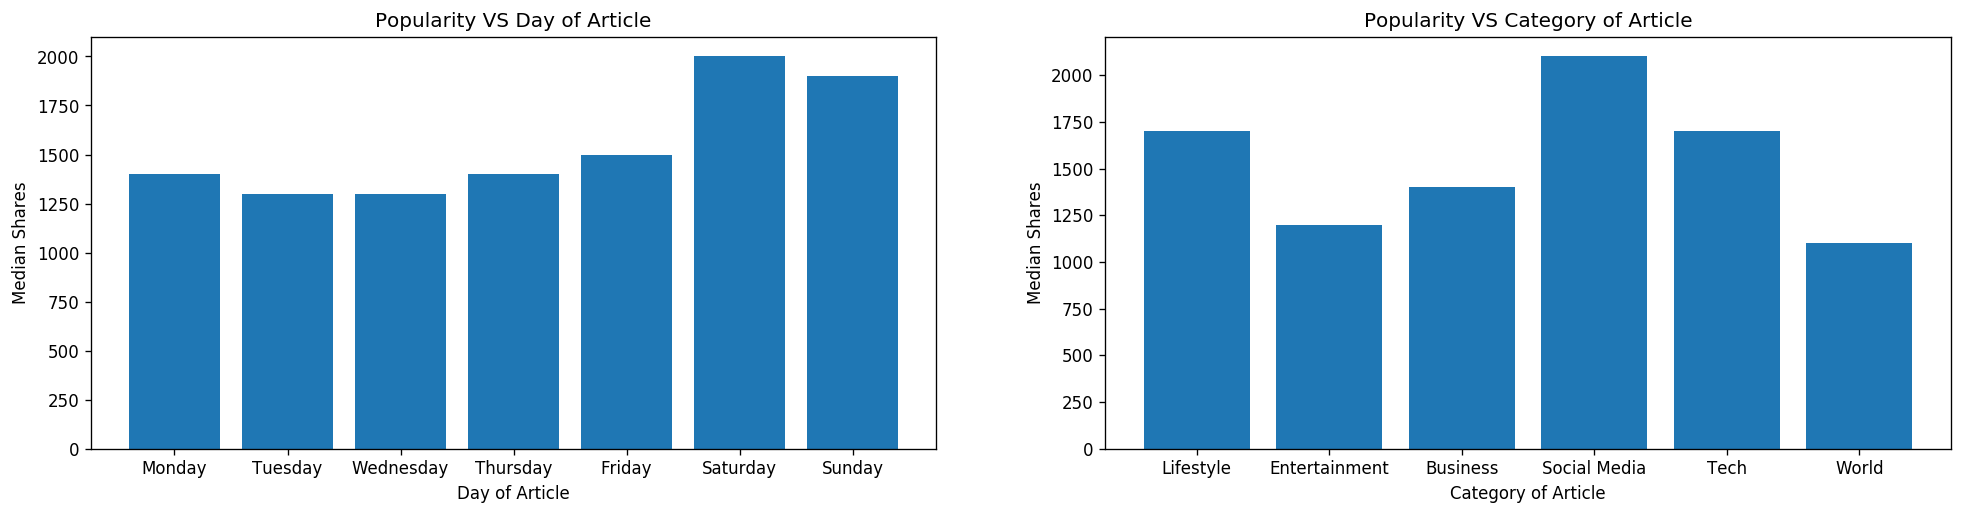

In [5]:
def binary_variable(table):
    #There are 7 Days in the data. 

    Week = [' weekday_is_monday',' weekday_is_tuesday',' weekday_is_wednesday',' weekday_is_thursday',
            ' weekday_is_friday',' weekday_is_saturday', " weekday_is_sunday"] 


    median_shares_per_day = [] 

    for day in Week: 

        temp_df = table.loc[:, [day," shares"]] 

        temp_df = temp_df[temp_df[day]==1] 

        median_shares_per_day.append(temp_df[" shares"].median()) 



    #There are 6 categories in the data - Lifestyle, Entertainment, Business, Social Media, Tech, World. 

    Ctgr = [" data_channel_is_lifestyle"," data_channel_is_entertainment"," data_channel_is_bus"," data_channel_is_socmed"," data_channel_is_tech"," data_channel_is_world"] 


    median_shares_per_category = [] 

    for category in Ctgr: 

        temp_df = table.loc[:, [category," shares"]] 

        temp_df = temp_df[temp_df[category]==1] 

        median_shares_per_category.append(temp_df[" shares"].median()) 



    plt.figure(figsize=(20,10))
    plt.figure(1)  

    #Plotting day and popularity     
    plt.subplot(221)
    plt.bar([1,2,3,4,5,6,7],median_shares_per_day) 

    plt.xticks([1,2,3,4,5,6,7], ["Monday","Tuesday","Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]) 

    plt.xlabel('Day of Article') 

    plt.ylabel('Median Shares') 

    plt.title('Popularity VS Day of Article') 

    #Plotting categories and popularity     
    plt.subplot(222)
    plt.bar([1,2,3,4,5,6],median_shares_per_category) 

    plt.xticks([1,2,3,4,5,6], ["Lifestyle","Entertainment","Business", "Social Media", "Tech", "World"]) 

    plt.xlabel('Category of Article') 

    plt.ylabel('Median Shares') 

    plt.title('Popularity VS Category of Article') 

    plt.show()
    
binary_variable(table)

**Remarque :**
* La médiane est préférée dans ce cas dû au fait du grand nombre d'outliers. En effet la médiane est un estimateur robuste qui ne prend pas en compte les valeurs extrêmes.
* On remarque que le nombre de partages d'articles semble plus élevé le week-end est moins élevé en semaine. 

* Il semble que certains domaines on tendance à être plus partagé que d'autres (ex : `Social Media` et `Lifestyle`)


**Conclusion binary variables :**  
Un article publié le week-end avec pour thème `Social Media` semble avoir plus de chance d'avoir un plus grand nombre de partages. qu'un article publié le mercredi avec pour thème `World`.



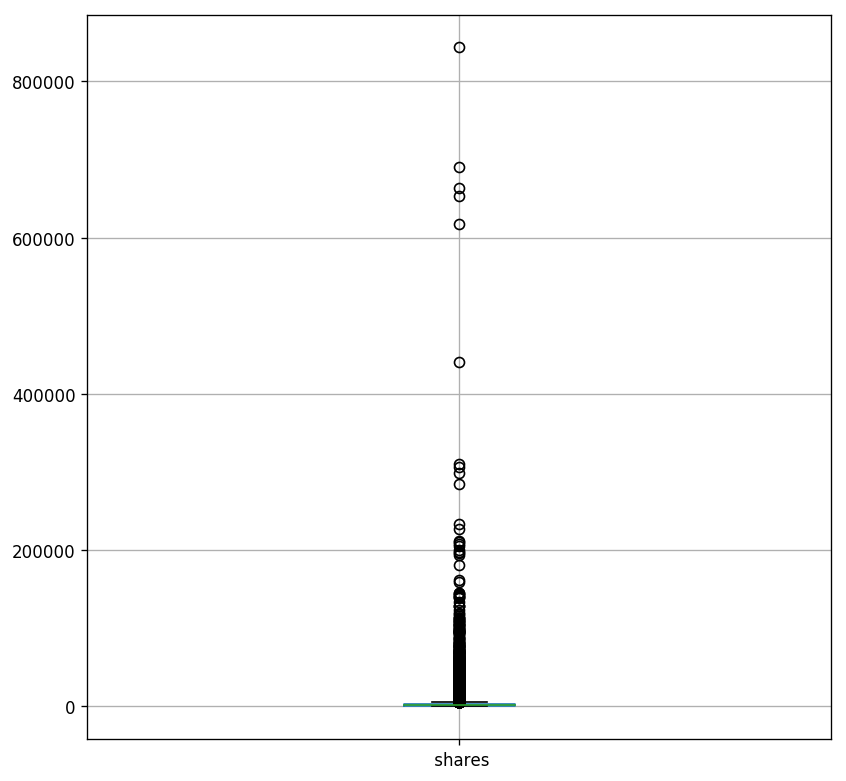

In [6]:
# Analyze variable shares 
table[[' shares']].boxplot()


plt.show()

**Remarque :**
- Le jeu de données possède une grande quantité d'outliers dû aux articles considérés viraux. Pour Rappel 75% des articles sont partagés moins de 2800 et l'article le plus partagé l'a été plus de 800000 fois.
- Pour ne pas fausser les algorithmes dus aux outliers je fais le choix de ne conserver que les articles ayant moins de 4000 partages.
- En effet à première vue il semble compliquer de pouvoir prédire avec précision 800000 partages si plus des 3/4 n'ont pas dépassé 2400.

**Idée :**
Il serait intéressant pour la suite de prédire non pas un nombre de partage mais des catégories. (ex : (1) médiocre (2), populaire, (3) virale )

number of article in the viral box  6495


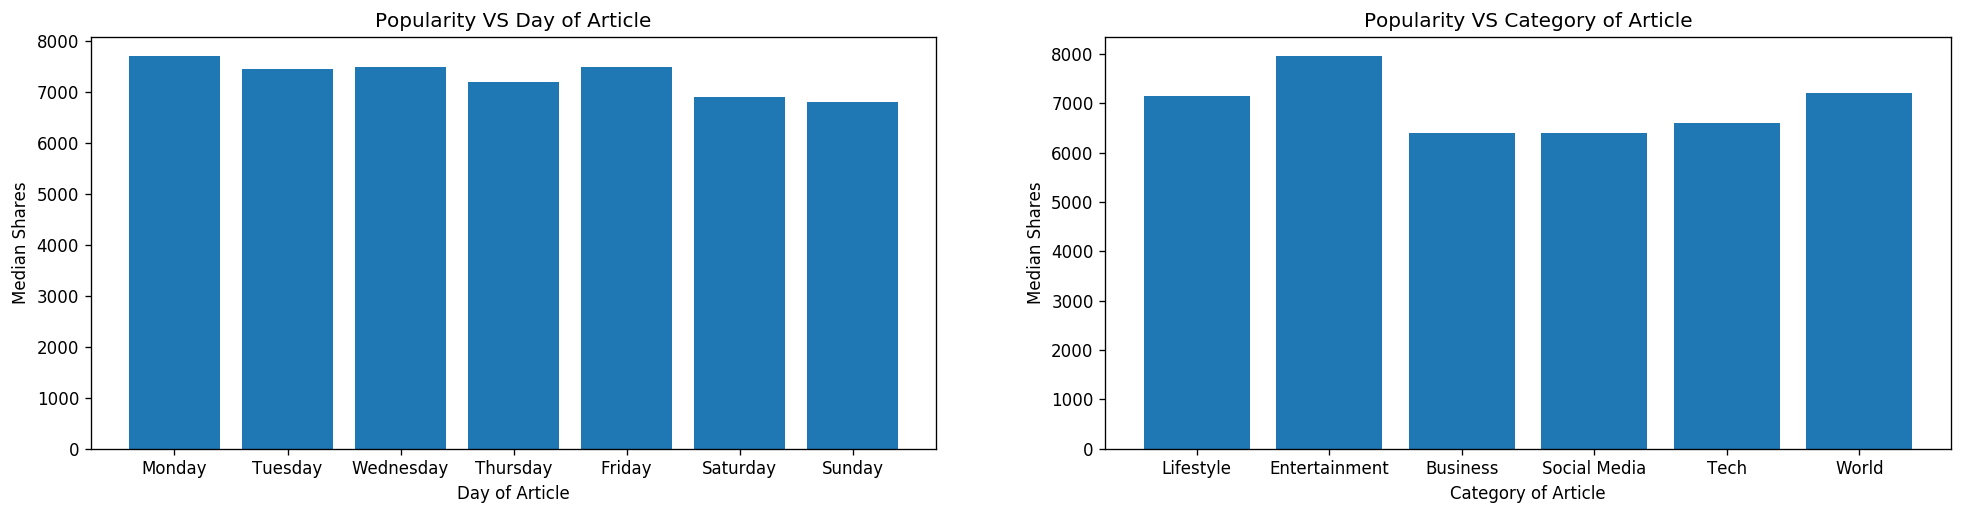

number of article in the mediocre box  460


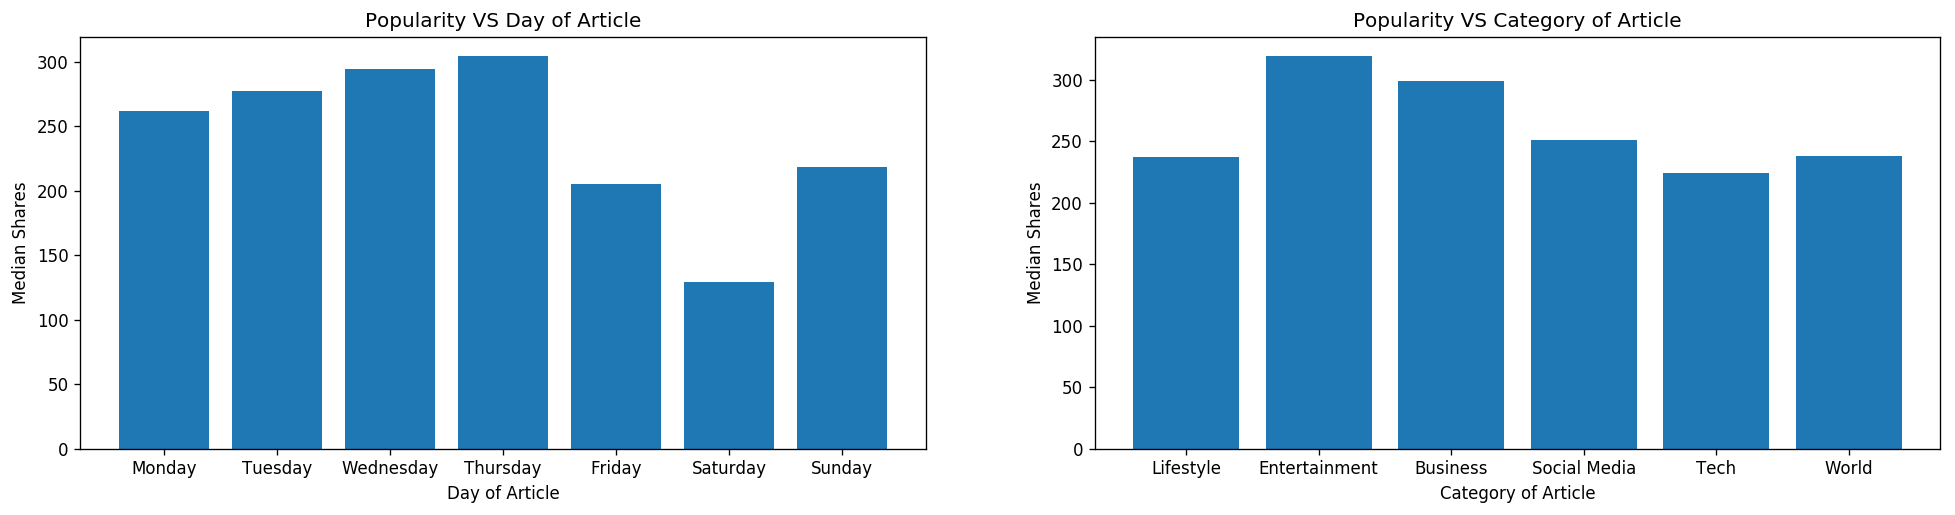

In [11]:
table_viral = table[table[' shares'] > 4000]
print("number of article in the viral box ",table_viral.shape[0],)

binary_variable(table_viral)

table_poor = table[table[' shares'] < 400]
print("number of article in the mediocre box ",table_poor.shape[0],)

binary_variable(table_poor)


**Remarque :**
- Il est intéressant de remarquer que la tendance s'inverse quand on est dans les extrêmes (virale & médiocre). En effet on remarque que les articles viraux sont plus souvent partagés en semaine que le week-end. De même on remarque que le samedi contient le plus faible (en médiane) nombre de partage pour les articles dans la catégorie.

**Conclusion**
- Pour la suite ne nous intéresserons qu'à l 'analyse des articles compris ]400,4000[. Un peu moins de 7000 articles sont supprimés. Une analyse en amont cherchant à catégoriser dans un premier temps permettrait de les conserver. 


**PS :** Un [kaggle](https://www.kaggle.com/c/predicting-online-news-popularity) a été lancé dans ce but précis avec pour meilleur résultat une précision de 0.56 pour classifier (dans 5 catégories). 


In [7]:
table_new = table[table[' shares']<4000 ]
table_new = table_new[table_new[' shares']>400 ]

table_new.describe()

print("number of article ",table_new.shape[0],)


number of article  32519


In [13]:
# Other variable
# Avoid singularity i keep only avg variables

Other_variables = [' n_unique_tokens',' n_non_stop_words',' n_non_stop_unique_tokens',' global_rate_positive_words',
                  ' global_rate_negative_words',' rate_positive_words',' rate_negative_words', ' LDA_00',' LDA_01',
                  ' LDA_02',' LDA_03',' LDA_04',' global_subjectivity',' avg_positive_polarity',' avg_negative_polarity',
                  ' title_subjectivity',' abs_title_subjectivity', ' abs_title_sentiment_polarity',
                  ' n_tokens_title',' n_tokens_content',' num_hrefs',' num_self_hrefs',' num_imgs',' num_videos',
                    ' num_keywords'
                   ,' average_token_length',' kw_avg_avg',' kw_avg_min',' kw_avg_max',
                       ' self_reference_avg_sharess',' global_sentiment_polarity', ' title_sentiment_polarity']



//anaconda/lib/python3.5/site-packages/biokit/viz/linkage.py:41: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = hierarchy.linkage(D, method=method, metric=metric)


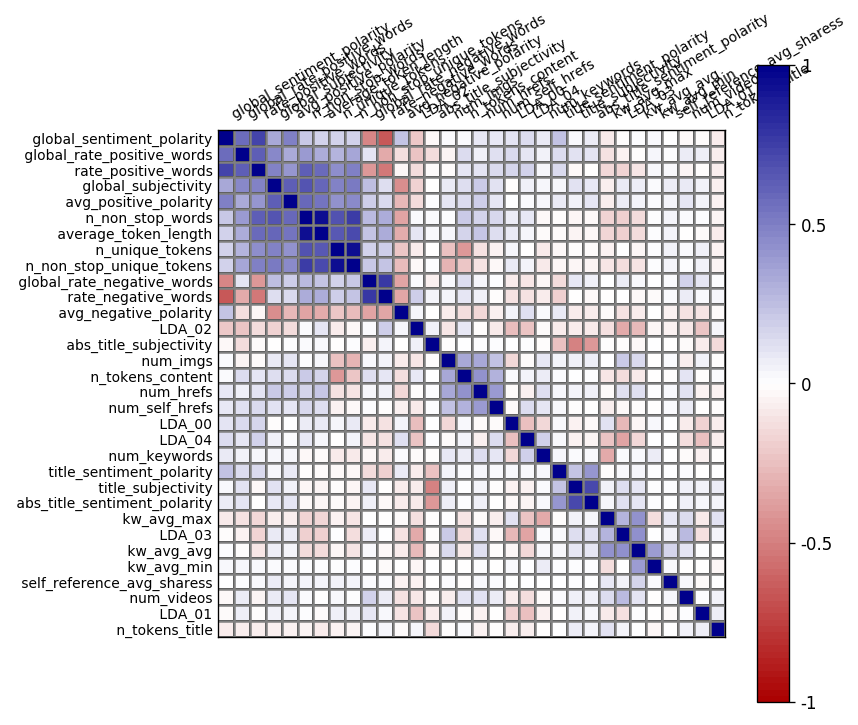

In [17]:
#Need to scale data due of magnitude's difference
table_other_scale = pd.DataFrame(preprocessing.scale(table[Other_variables], axis=0),
                                  columns =Other_variables)

c_d = corrplot.Corrplot(table_other_scale.corr())
c_d.plot(method='color')

plt.show("correlation Other")

**Remarque :**  
-  Un grand nombre de variables est corrélé entre elles. Des variables ayant une trop forte corrélation peuvent entraîner des problèmes par la suite (ex : Régression linéaire)
- De plus cette forte corrélation nous laisse à penser qu'il est possible de reconstruire les variables sans perdre (trop) d'information ainsi que réduire leur nombre.

**Conclusion :**
Nous allons procéder à une **A**nalyse en **C**omposition **P**rincipal.

cummulative variance expliqué : [ 0.16992204  0.27280356  0.36085439  0.43567221  0.49853811  0.54531341
  0.58467043  0.62316329  0.65924434  0.6922359   0.72489321  0.75412642
  0.78192332  0.80901836  0.83399933  0.85644247  0.87687806  0.89646164
  0.91537344  0.93203125  0.94743266  0.96022938  0.96986233  0.9783563
  0.98580339  0.99229438  0.99531804  0.99751434  0.99911596  0.99996503
  1.          1.        ]


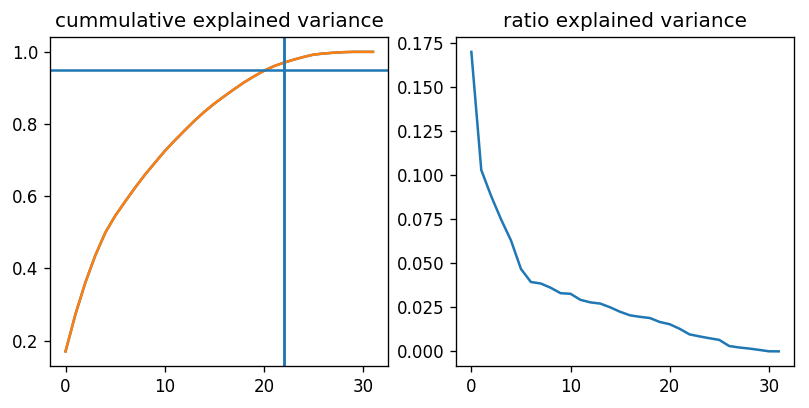

In [20]:
# ACP
pca = PCA()

pca.fit(table_other_scale)

print("cummulative variance expliqué :", pca.explained_variance_ratio_.cumsum(),)

plt.subplot(221)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.axvline(x=22)
plt.axhline(y=0.95)
plt.title("cummulative explained variance")
plt.subplot(222)
plt.plot(pca.explained_variance_ratio_)
plt.title("ratio explained variance")
plt.show()

**Remarque :**
- Les 22 premiers vecteurs propres expliquent plus de 95% de la dispersion du jeu de données.
-  Dans le but de conserver le plus d'informations possible nous conserverons les 22. Une analyse pour sélectionner les variables les plus explicatives se fera an aval.

In [27]:
pca1 = PCA(n_components=22)

pca_1 = pca1.fit_transform(table_other_scale)
name_pca = ["pca_1","pca_2","pca_3","pca_4","pca_5","pca_6","pca_7","pca_8","pca_9","pca_10","pca_11","pca_12",
            "pca_13","pca_14","pca_15","pca_16","pca_17","pca_18","pca_19","pca_20","pca_21","pca_22"]

new_table = pd.DataFrame(pca_1,columns=name_pca)


components = pd.DataFrame(pca1.components_,index = name_pca, columns = Other_variables).T

def color_negative_red(value):
  """
  Colors elements in a dateframe
  green if positive and red if
  negative. Does not color NaN
  values.
  """

  if abs(value) < 0.3:
    color = 'red'
  else:
    color = 'green'

  return 'color: %s' % color

components.style.applymap(color_negative_red)

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22
n_unique_tokens,-0.321579,0.0958394,-0.127359,-0.284594,0.0243566,0.112715,0.00374467,-0.101774,0.00845227,0.0598269,-0.0376696,-0.0412573,0.219746,-0.16962,0.00684286,-0.0377413,-0.0340555,-0.0497636,-0.00136688,-0.0799142,0.033164,-0.112447
n_non_stop_words,-0.394034,0.108638,-0.0599678,0.071466,-0.0272616,-0.0592315,0.0647462,-0.0379887,0.0288849,0.0765632,0.0297485,-0.0523058,0.0365167,0.0172682,-0.0414383,-0.0288048,-0.00532809,-0.120488,-0.099347,-0.13591,0.00956433,0.170753
n_non_stop_unique_tokens,-0.347598,0.103123,-0.160245,-0.216044,-0.0190491,0.0510049,0.0270824,-0.0451141,-0.00896344,0.0264013,0.0298951,-0.030278,0.163338,-0.0942135,0.000302166,-0.0110538,-0.0283983,-0.000347463,-0.0207013,-0.0868979,0.0382998,0.0386096
global_rate_positive_words,-0.258089,-0.207834,0.0884303,-0.0244403,-0.0131902,-0.0409327,-0.113891,0.197512,-0.0799775,-0.197071,0.124263,0.0497286,-0.191106,0.106043,0.190689,-0.159533,-0.440558,0.182818,0.189414,-0.149288,0.219589,-0.186448
global_rate_negative_words,-0.0836421,0.425834,0.104975,0.0124188,-0.0905085,0.0486539,-0.0177821,0.21531,-0.163413,-0.142541,0.010064,0.00668739,-0.101263,0.106752,-0.0981485,-0.274389,-0.211779,0.211903,0.151401,-0.0469721,0.132119,-0.13238
rate_positive_words,-0.31449,-0.321849,-0.0553226,0.0171834,0.0495649,-0.0773009,-0.022394,-0.0685998,0.0767433,0.0430845,0.0802093,-0.00774922,-0.000125768,0.000869945,0.128546,0.0682809,-0.0530696,-0.142909,-0.0749766,-0.142553,0.00888666,0.100581
rate_negative_words,-0.0464015,0.510174,0.00264761,0.0574753,-0.0905251,0.0297763,0.0971969,0.0425236,-0.0619227,0.0306663,-0.0645665,-0.0477131,0.0379057,0.0185775,-0.20188,-0.114243,0.0590863,0.0441029,-0.0162685,0.0271889,-0.00131946,0.0622709
LDA_00,-0.0435909,-0.0952514,-0.0731057,-0.0950665,0.0782529,-0.489982,0.303208,0.414422,-0.0990811,-0.137826,-0.0564408,-0.0594326,-0.138771,-0.366224,-0.178607,0.000649865,0.118618,-0.0634839,0.0276542,-0.0258205,-0.109353,-0.124266
LDA_01,-0.0221006,0.0452254,0.0634949,-0.0647593,-0.0542317,0.0413855,-0.5842,0.406551,0.375918,0.171993,-0.00265749,0.193001,0.229227,0.0448052,-0.0523824,0.029515,0.0877928,0.123247,-0.218065,-0.0542006,0.0208361,0.0141324
LDA_02,0.0536856,0.137388,-0.206589,0.134524,-0.209885,-0.146004,0.174222,-0.470894,0.372783,-0.0964533,0.135445,0.139593,-0.0288802,0.150969,0.169822,-0.0419116,-0.135048,0.230242,0.0368798,-0.00713251,-0.146258,-0.189268


**Remarque :**
- En vert sont représentées les caractéristiques qui sont mises en avant par chaque vecteur propre.  
pca_1 : taux d'unique non-stop mots.  
pca_2 : taux de mots négatifs (positifs)     
pca_3 : Niveau de polarité dans les titres  
pca_4 : Nombre de références liées par article  
.  
.  
.  



//anaconda/lib/python3.5/site-packages/biokit/viz/linkage.py:41: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = hierarchy.linkage(D, method=method, metric=metric)


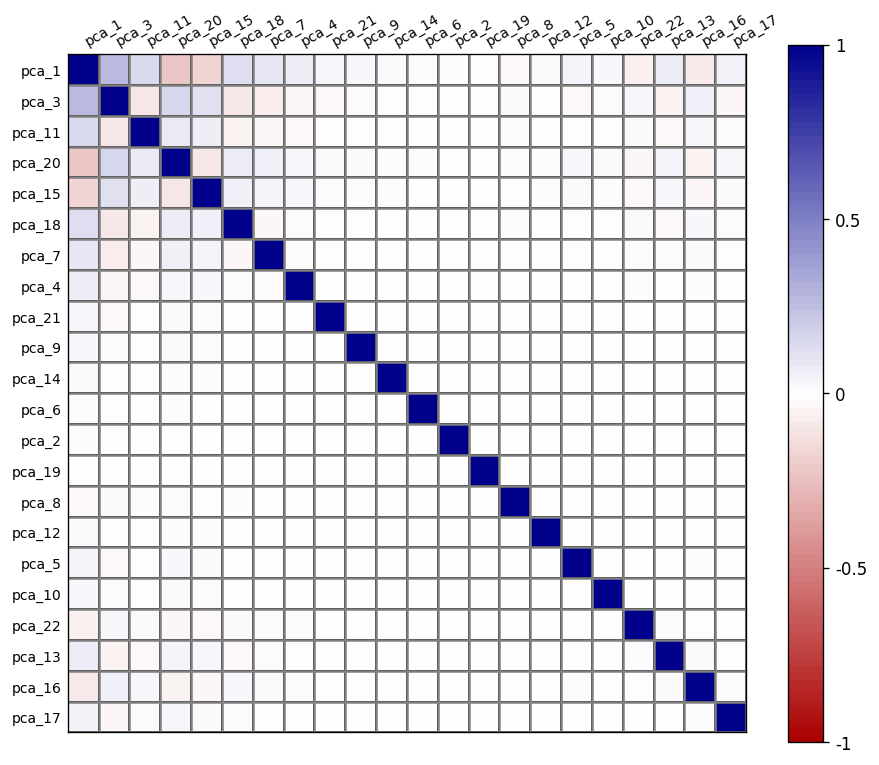

In [12]:
c_pca = corrplot.Corrplot(components.corr())
c_pca.plot(method ='color')
plt.show()

**Remarque :**
* Nous avons conservé 22 variables. Une corrélation persiste mais semble acceptable pour la suite.



# Machine learning

<hr style="border-width:2px;border-color:#3CB371">


Nous pouvons donc passer à la partie Machine learning. Nous allons procéder à une approche simple de régression linéaire. Celle-ci a pour hypothèse que la variable cible est une combinaison linéaire des variables explicatives. De plus elle fait partie des méthodes les plus utilisées. Elle possède donc de nombreux outils permettant de mieux comprendre le fonctionnement de la variable cible.   
Nous allons directement utiliser une régression avec pénalité L1 dans le but de faire une sélection de variables.

*Rappel :* si la pénalité est nulle la régression Lasso <=> à une régression linéaire simple

* Il est préférable de centrer et réduire les variables dans la régression régularisée afin que le coefficient de pénalité `α` agi de manière homogène sur l'ensemble des coefficients de la régression.



In [31]:
components.to_csv("mat_reduce.csv", index=False)

coefficient estimé  with alpha 1.0: [ 0.  0.  0. -0.  0. -0.  0. -0. -0.  0.  0.  0. -0.  0.  0. -0. -0.  0.
 -0. -0. -0.  0.]


//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)


(22, 14)


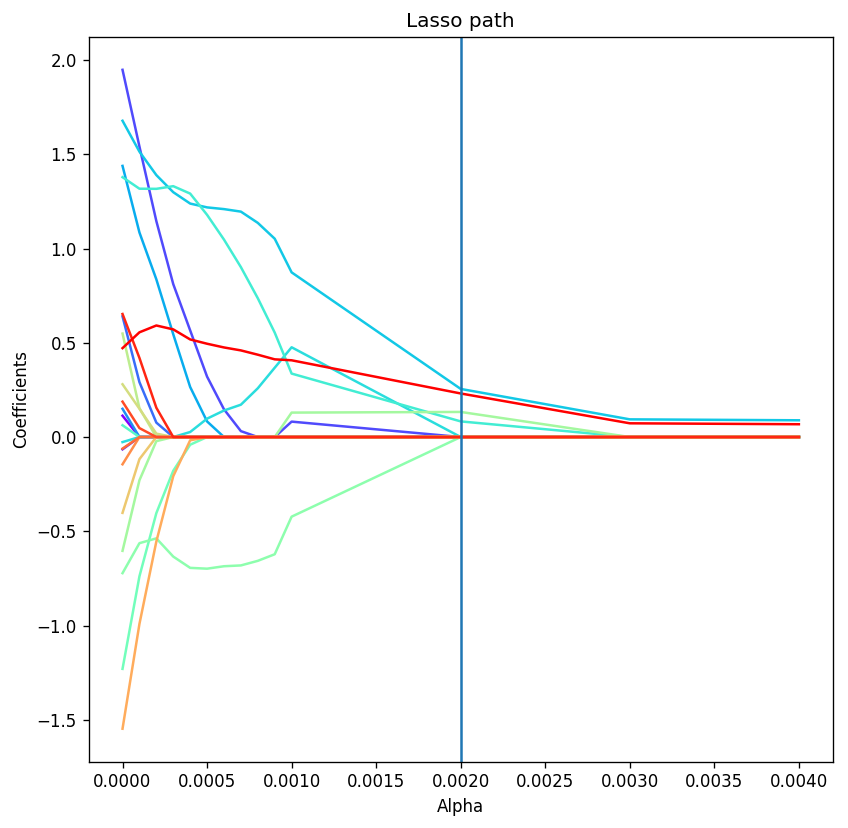

In [13]:
X = table_new[Other_variables].dot(components)
X.columns = name_pca
data = pd.concat([X,Y], axis=1)

#Separate in Train(0.8%) and Test(0.2)
X_train, X_test, Y_train, Y_test = train_test_split(X, table_new[' shares'], test_size=0.2, random_state=5)

Train=pd.concat([X_train,Y_train], axis=1)

#center and reduce

sc = StandardScaler()
ZTrain =sc.fit_transform(Train)

ZTrain.shape

regLasso1 = Lasso(fit_intercept=False,normalize=False)

#Learning step
regLasso1.fit(ZTrain[:,:22],ZTrain[:,22])

print("coefficient estimé  with alpha 1.0:",regLasso1.coef_,)

#lasso path (14 alpha test values)
my_alphas = np.array([0,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.002
                      ,0.003,0.004])

#obtention des valeurs des coefs. corresp.

alpha_for_path, coefs_lasso, _ = lasso_path(ZTrain[:,:22],ZTrain[:,22],alphas=my_alphas)

#dim. matrix coef
print(coefs_lasso.shape)

couleurs = cm.rainbow(np.linspace(0,1,22))
#plot lasso path (une courbe par variable)
for i in range(coefs_lasso.shape[0]):
    plt.plot(alpha_for_path,coefs_lasso[i,:],c=couleurs[i])
plt.axvline(x=0.002)
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso path')
plt.show()

In [459]:
#Value of coeff for alpha = 0.002
nom_var = X.columns

coefs2 = coefs_lasso[:,2]

print("valeur des coefficients pour alpha = 0.002\n",pd.DataFrame({'Variables':nom_var,'Coefficients':coefs2}),)

valeur des coefficients pour alpha = 0.002
     Coefficients Variables
0      -0.000000     pca_1
1      -0.000000     pca_2
2       0.000000     pca_3
3       0.000000     pca_4
4       0.000000     pca_5
5       0.000000     pca_6
6       0.255148     pca_7
7       0.000000     pca_8
8       0.082888     pca_9
9      -0.000000    pca_10
10     -0.000000    pca_11
11     -0.000000    pca_12
12      0.133069    pca_13
13      0.000000    pca_14
14      0.000000    pca_15
15      0.000000    pca_16
16     -0.000000    pca_17
17     -0.000000    pca_18
18     -0.000000    pca_19
19      0.000000    pca_20
20      0.000000    pca_21
21      0.231030    pca_22


**Remarque :**  
Quand alpha croit le nombre de coefficients nul croit aussi. Les coefficients qui prennent le plus de temps à être amenés à zéro sont ceux dont la pénalité impact le moins. C'est-à-dire que même en pénalisant il est préférable de les conserver, le contraire entraînerait une augmentation de l'erreur.

* Pour une pénalité de 0.002 4 variables sont conservées et 3 avec un coeff significatif: pca_7, pca_13, pca_22  

**Rappel :**  
pca_7 impact positivement (`LDA_00` et `Kw_avg_min`)  impact négativement (`LDA_01`)  
pca_13 impact positivement (`num_self_href`)  
pca_22 impact positivement (`LDA_03` et `n_tokens_content`)  

In [14]:
#cv = 5 for 5-fold cross-validation

lcv = LassoCV(alphas=my_alphas,normalize=False,fit_intercept=False,random_state=0,cv=5)

lcv.fit(ZTrain[:,:22],ZTrain[:,22])

print("best alpha :", lcv.alpha_,)

print("Coeff estimé avec la cross validation\n",lcv.coef_,)

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  tol, rng, random, positive)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:1211: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  model.fit(X, y)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: Conv

best alpha : 0.0
Coeff estimé avec la cross validation
 [ 0.76286528 -0.14461397  0.88273128  0.74883829  0.35957696  0.83987592
  1.40252005  1.23920203  0.1879918   0.28424975 -0.30556935 -1.26125574
 -0.21234902 -0.03446414  0.00735269 -0.36663717 -0.65952709 -0.21066343
 -0.1161881   0.19638649  0.34532213  0.48017494]


**Conclusion :**  
L'approche Lasso nous a permis d'avoir certaines informations sur le fonctionnement du nombre de partages, tel que les thèmes préférés, l'intérêt d'avoir des hyperliens vers d'autres articles de sa page ainsi qu'avoir un article possédant un certain nombre de mots.   
mais cependant pénaliser induit une perte de précision. Pour la suite nous utiliserons donc une régression linéaire simple. 


number of shares error 
 646.0358765446922


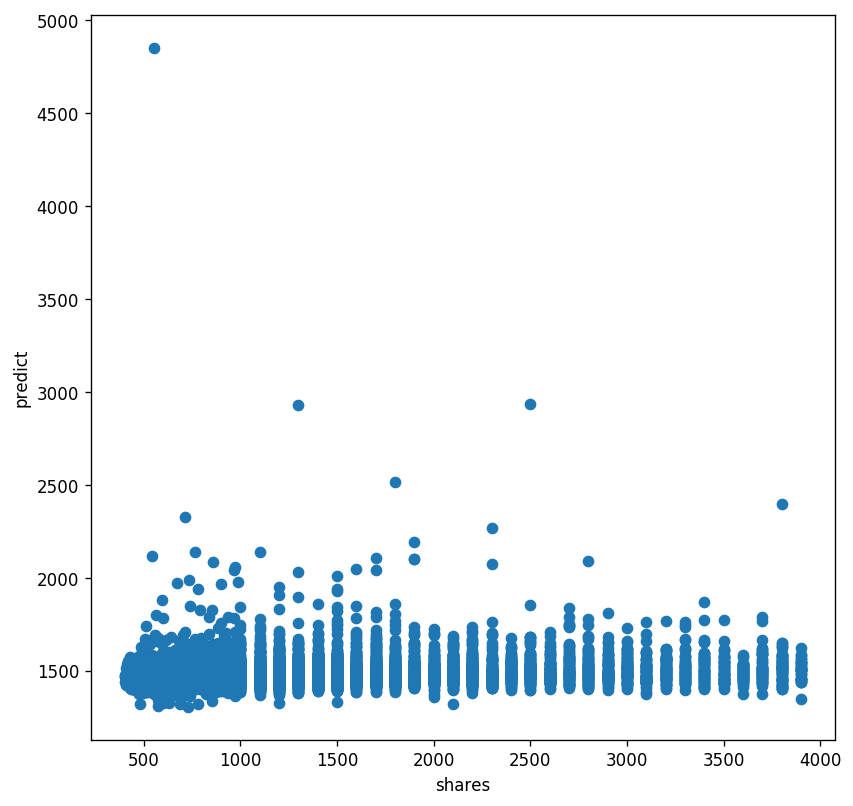

mean_square 14.7602787546


In [509]:
# Predict on test data
Test = pd.concat([X_test,Y_test], axis=1)
ZTest = sc.transform(Test)

Y_pred_test = ZTest[:,:22].dot(lcv.coef_)

Y_pred_test = Y_pred_test*np.sqrt(sc.var_[-1]) + sc.mean_[-1]

score_mean_error = np.mean(np.abs(Y_pred_test - Y_test))

print("number of shares error \n",score_mean_error,)


plt.scatter(Y_test, Y_pred_test)
plt.xlabel('shares')
plt.ylabel('predict')
plt.show()

mean_square = np.sqrt(np.mean((Y_test - Y_pred_test))**2)

print("mean_square",mean_square)

# Conclusion 
<hr style="border-width:2px;border-color:#3CB371">

## Résultat de l'analyse
* Le modèle de régression linéaire même peu performant (avec une moyenne d’erreur sur l’échantillon de test de 646)nous aura donné certaines informations sur le comportement de la variable `share`. En effet si le but d'un site est d’assurer un certains nombres convenables de partage nous pouvons lui conseiller de préférer les domaines tels que `social media` ou `world` que  `entertainement`. 
* De plus, publier le week end semble augmenter les chances de partage avec une médiane plus élevée qu'en semaine. Cependant, l'analyse des articles dans la catégorie médiocre montre que le week-end a la proportion la plus faible de partage.
* L'analyse nous montre aussi qu'il est préférable d'avoir un article contenant du texte que des images et que mettre des liens sur d'autres articles du même site a tendance à booster le nombre de partage.
## Piste D'amélioration
* La régression linéaire a du mal à prédire les valeurs aux extrémités. celle-ci est biaisée par la dispersion des données avec plus de la moitié comprises entre 980 et 2800. Il pourrait donc être utile de prédire non pas un nombre de partage mais une catégorie (ex :(1) médiocre (2), populaire, (3) viral) et d’utiliser des méthodes de re-sampling pour contrecarrer le problème d'`imbalanced class`.
* Un benchmark de tous les algorithmes connus en régression aurait permis une diminution de l'erreur, cependant cette analyse s'intéresse en priorité sur les phénomènes qui peuvent entraîner une augmentation plus que sur le score d'un algorithme. 
